In [1]:
%load_ext autoreload

In [250]:
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sdeint import itoint
from spynal.spectra.multitaper import multitaper_spectrogram
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from tqdm.auto import tqdm

In [190]:
def f(x, t, A):
    return A @ x

def G(x, t, noise_scale):
    return np.eye(x.shape[0])*noise_scale

In [262]:
def simulate_system(decay_rate, freq, t_span=[0, 5], dt=0.0005, num_trajs=2, noise_scale=0, verbose=False):
    np.random.seed(42)
    Lambda = np.array([[-decay_rate, freq*2*np.pi], [-freq*2*np.pi, -decay_rate]])
    V = np.random.randn(Lambda.shape[-1], Lambda.shape[-1])
    
    A = V @ Lambda @ np.linalg.inv(V)
    
    t_eval = np.arange(t_span[0], t_span[1], dt)
    T = len(t_eval)
    
    n = A.shape[-1]
    
    x = np.zeros((num_trajs, T, n))

    for num_traj in range(num_trajs):
        y0 = np.random.randn(n)
        if noise_scale == 0:
            sol = solve_ivp(lambda t, x: f(x, t, A=A), y0=y0, t_span=t_span, t_eval=t_eval)
            x[num_traj] = sol.y.T
        else:
            x[num_traj] = itoint(lambda x, t: f(x, t, A=A), lambda x, t: G(x, t, noise_scale=noise_scale), y0, t_eval)
        
    # dW = np.random.randn(*x.shape)
    # x[:, 0] = np.random.randn(num_trajs, n)
    # for t in tqdm(range(1, T), disable=not verbose, desc='Simulating System'):
        # x[:, t] = x[:, t-1] + dt*(A@x[:, t-1].T).T + np.sqrt(dt)*noise_scale*dW[:, t]
        

    return x, t_eval

def compute_spectrum(x, dt):
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    ffts = np.fft.rfft(x.transpose(0, 2, 1).reshape(x.shape[0]*x.shape[2], x.shape[1]))
    ffts = ffts.reshape(x.shape[0], x.shape[2], -1) # trials x inds x freqs
    fft_mags = np.abs(ffts)
    fft_angles = np.angle(ffts)

    return ffts, freqs, fft_mags, fft_angles

def compute_spectra(x, dt, time_width=0.5):
    spec, freqs_spec, time_pts = multitaper_spectrogram(x.transpose(1, 0, 2).reshape(x.shape[1], -1), 1/dt, time_width=time_width)
    spec = spec.reshape(spec.shape[0], spec.shape[1], x.shape[0], x.shape[2]).transpose(2, 3, 0, 1) # trials x inds x freqs x time
    spec_mags = np.abs(spec)
    spec_angles = np.angle(spec)

    return spec, freqs_spec, spec_mags, spec_angles

In [263]:
t_span = [0, 5]
dt = 0.001
num_trajs = 10
noise_scale = 0
time_width = 1

# More stable, and delta

In [274]:
decay_rate = 0.1
freq = 4

x, t_eval = simulate_system(decay_rate, freq, t_span, dt, num_trajs, noise_scale)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x, dt)
spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x, dt, time_width=time_width)

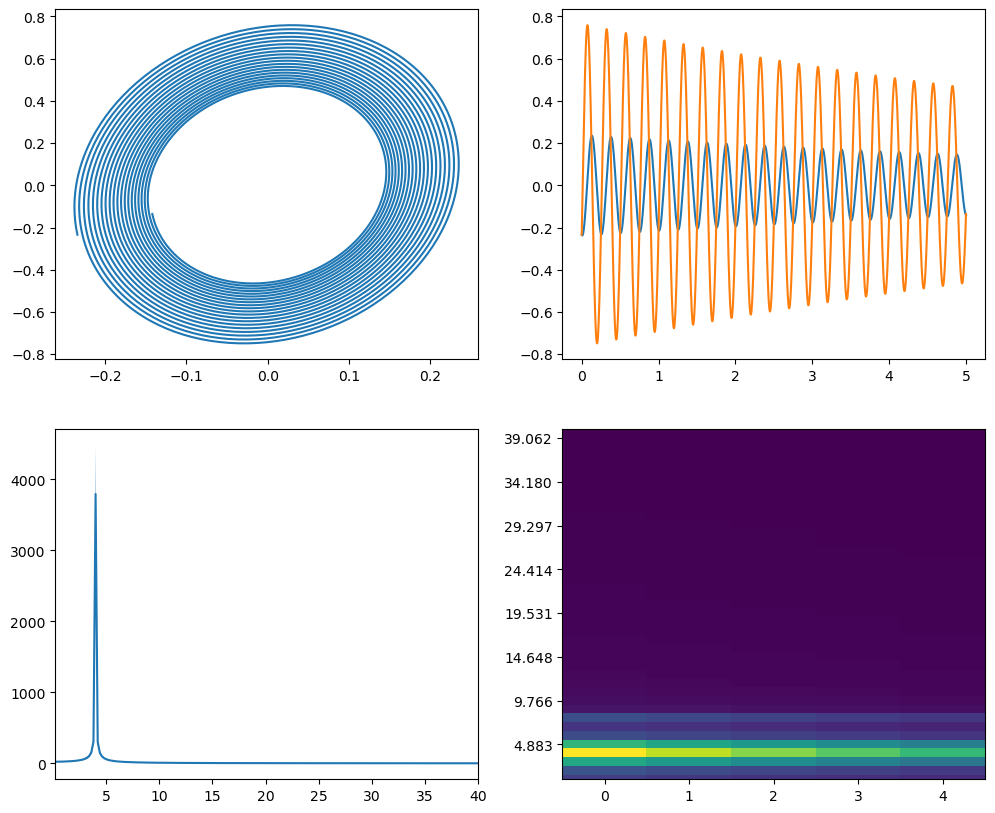

In [275]:
max_freq = 40
min_freq = freqs[1]

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)

ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
min_ind = np.argmax(freqs_spec >= min_freq)
max_ind = np.argmin(freqs_spec <= max_freq)
ax.set_ylim([min_ind, max_ind])
yticks = ax.get_yticks()
ylim = ax.get_ylim()
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()

# Less stable, and gamma

In [276]:
decay_rate = 0.01
freq = 30

x, t_eval = simulate_system(decay_rate, freq, t_span, dt, num_trajs, noise_scale)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x, dt)
spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x, dt, time_width=time_width)

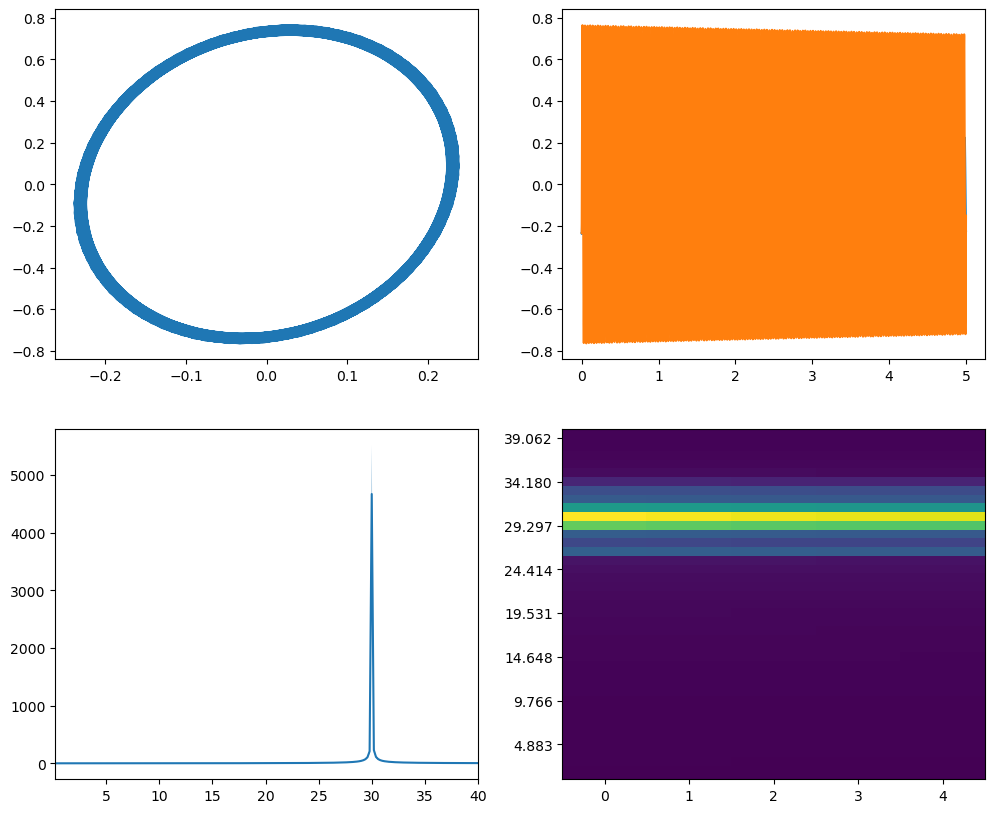

In [277]:
max_freq = 40
min_freq = freqs[1]

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)

ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
min_ind = np.argmax(freqs_spec >= min_freq)
max_ind = np.argmin(freqs_spec <= max_freq)
ax.set_ylim([min_ind, max_ind])
yticks = ax.get_yticks()
ylim = ax.get_ylim()
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()

# Van Der Pol Oscillator

In [372]:
def vdp(t, x, mu):
    x, y = x
    dxdt = y
    dydt = mu*(1 - x**2)*y - x

    return np.array([dxdt, dydt])

In [441]:
mu = 3
# mu = 45

In [442]:
t_span = [0, 200]
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)


In [443]:
num_trajs = 1
x = np.zeros((num_trajs, T, 2))

for num_traj in tqdm(range(num_trajs)):
    y0 = np.random.randn(2)
    sol = solve_ivp(lambda t, x: vdp(t, x, mu=mu), y0=y0, t_span=t_span, t_eval=t_eval)
    x[num_traj] = sol.y.T

  0%|          | 0/1 [00:00<?, ?it/s]

In [444]:
time_width = 20
transient = int(T*0.1)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x[:, transient:], dt)
spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x[:, transient:], dt, time_width=time_width)

In [445]:
pred_period = (3 - 2*np.log(2))*mu + 2*np.pi/(mu**(1/3))

In [446]:
1/pred_period

0.10872360964407093

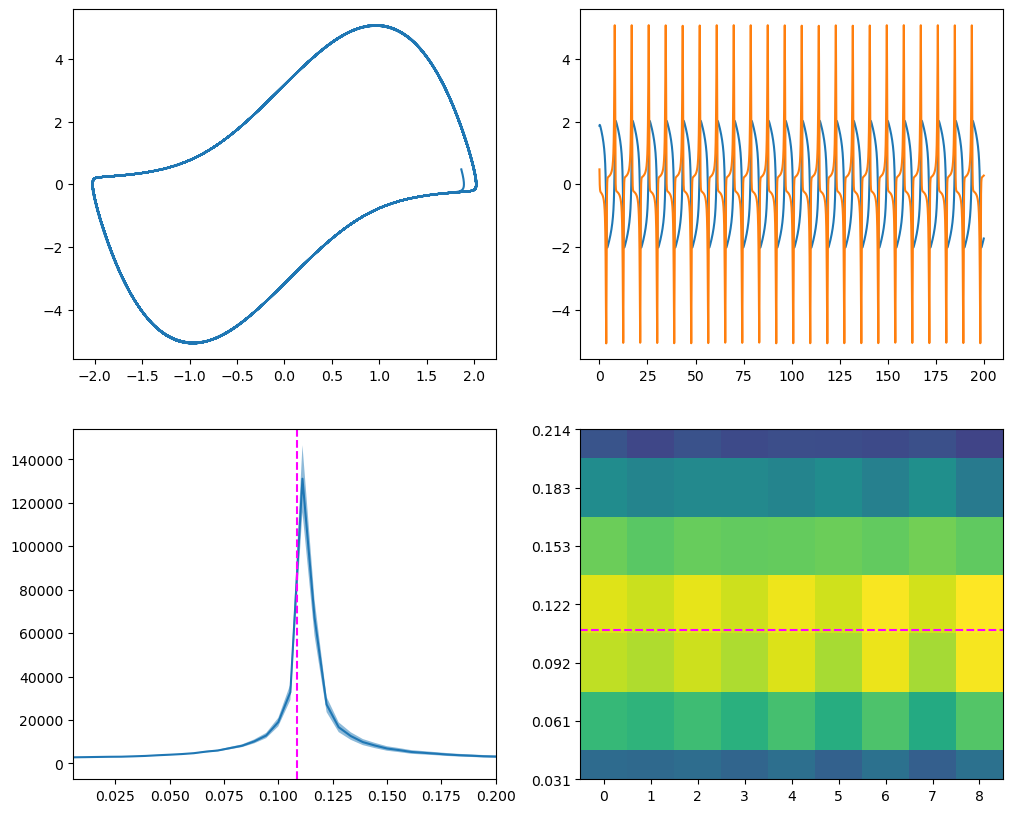

In [447]:
max_freq = 0.2
min_freq = np.min([freqs[1], freqs_spec[1]])

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)
ax.axvline(1/pred_period, linestyle='--', c='magenta')
ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
min_ind = np.argmax(freqs_spec >= min_freq)
max_ind = np.argmin(freqs_spec <= max_freq)
ax.set_ylim([min_ind, max_ind])
yticks = ax.get_yticks()
ylim = ax.get_ylim()
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.axhline((1/pred_period)/freqs_spec[1], linestyle='--', c='magenta')

plt.show()

In [427]:
mu_vals = np.linspace(1, 50, 1000)
period_vals = (3 - 2*np.log(2))*mu_vals + 2*np.pi/(mu_vals**(1/3))
freq_vals = 1/period_vals